# Import libraries and initial dataset


In [2]:
import os
import numpy as np
import pandas as pd
import time
import sys
# try:
#     sys.getwindowsversion()
# except AttributeError:
#     isWindows = False
# else:
#     isWindows = True
#use more RAM
# if isWindows:
#     import win32api,win32process,win32con
#     pid = win32api.GetCurrentProcessId()
#     handle = win32api.OpenProcess(win32con.PROCESS_ALL_ACCESS, True, pid)
#     win32process.SetPriorityClass(handle, win32process.HIGH_PRIORITY_CLASS)
from datetime import datetime
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [2]:
os.getcwd()

'C:\\Users\\ML\\Documents\\Capston1A\\NLPtools'

In [3]:
regular_reviews = pd.read_csv('data/reg_reviews_NLP.csv')
not_recommended_reviews= pd.read_csv('data/not_reviews_NLP.csv')

# Combine the datasets

New feature, 'regular', is added to distinguish regular review from not recommended reviews

- 1 represent regular reviews
- 0 represent not recommended reviews

In [4]:
regular_reviews['regular'] = 1
not_recommended_reviews['regular'] = 0

#I'm trying to keep some more data for analysis, esp the location and date
reviews = pd.concat([regular_reviews,not_recommended_reviews], join="inner")

# yao's avgSentiment

In [15]:
reviews['totSentimentYao'] = reviews['Sfreq0']+reviews['Sfreq1']*2+reviews['Sfreq2']*3+reviews['Sfreq3']*4+reviews['Sfreq4']*5
reviews['avgSentimentYao'] = reviews['totSentimentYao']/reviews['numSentence']

In [6]:
reviews['avgSentimentLee'] = reviews.avgSentiment+1

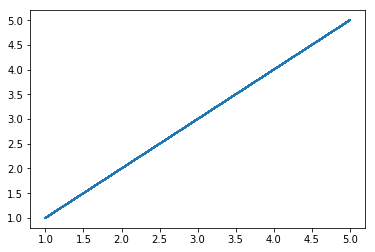

In [16]:
import matplotlib.pyplot as plt
plt.plot(reviews.avgSentimentLee, reviews.avgSentimentYao)
plt.show()

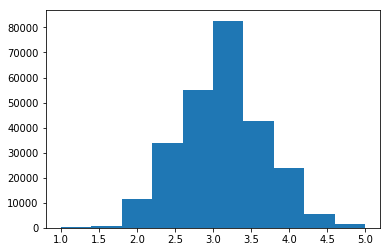

In [17]:
plt.hist(reviews.avgSentimentYao.dropna())
plt.show()

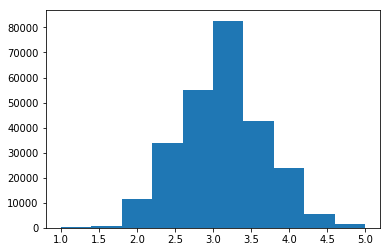

In [13]:
plt.hist(reviews.avgSentimentLee.dropna())
plt.show()

In [18]:
reviews.avgSentimentYao.describe()

count    257543.000000
mean          3.096453
std           0.570515
min           1.000000
25%           2.681818
50%           3.000000
75%           3.500000
max           5.000000
Name: avgSentimentYao, dtype: float64

# Drop missing values

In [5]:
len_before = len(reviews)
reviews = reviews.replace(-1, np.nan).replace('-1', np.nan).dropna()
len_after = len(reviews)
print('len_before', len_before, 'len_after', len_after, 'diff', len_before-len_after)

len_before 257587 len_after 251386 diff 6201


# testing, remove duplicates

In [6]:
# doesnt matter...very little difference after equal balancing,
# diff of 12 rows elimnated at then end and also reduces r2 slightly...even though a lot is removed initially

# len_before = len(reviews)
# reviews=reviews.drop_duplicates()
# len_after = len(reviews)
# print('len_before', len_before, 'len_after', len_after, 'diff', len_before-len_after)

## <span style="color:blue"> Data cleaning

- converted sentiment frequency count into frequency ratio

# Replace boolean to numerical value for 'has_photo'

In [7]:
reviews['has_photo'] = reviews['has_photo'].astype(int)

# Remove Sfreq 0-5, perhaps if we make extreme values for sentiment

which we found these features are less significant

In [8]:
#add features if very postive or very negative before dropping, similar to extreme feature
reviews['Rev_V_Negative'] = np.where(reviews['Sfreq0']>0, 1, 0)
reviews['Rev_V_Positive'] = np.where(reviews['Sfreq4']>0, 1, 0)

In [9]:
reviews.drop(columns=['Sfreq5','user_name', 'Sfreq0','Sfreq1','Sfreq2','Sfreq3','Sfreq4'], inplace=True)

In [10]:
# reviews.to_csv('data/reviewsBind.csv', index=True)

# <span style="color:blue"> New Features
## -  'extreme' : 
 - 1 for rating either 1 or 5,   
 - 2 for the rest rating values
 
## - 'storeReviewTot' : 
- total number of sampled reviews for each restaurant

## - 'storeReviewRatio' : 
- For each restaurant review, the ratio of not-recommended/regular reviews

### 'extreme' feature where rating == 1|5

In [11]:
#doesn't contribute, rating and rating diff already shows a good picture 
#reviews['Rating_Extreme'] = (reviews['rating'].isin([1,5])).astype(int)

# Date has a hidden feature to show if the user updated his review, extract

make a new feature for updated review

In [12]:
#there is a hidden feature in the date where if an user updates his post, it says the date and 'Updated_review', create extra feature

reviews.loc[reviews['date'].str.contains('Updated review'), 'Edited_Review_Bool'] = 1
#add 0s if not updated
reviews['Edited_Review_Bool'].fillna(0, inplace=True)
#remove extra formating
reviews['date'] = reviews['date'].map(lambda x: x.rstrip('Updated review').rstrip())

In [13]:
def compare_dates(date):
    date_format = '%m/%d/%Y'
    current_date = datetime.strptime(date, date_format)  
    start = datetime(2004,10,1)
    diff = current_date - start
    return diff.days

#apply this function to your pandas dataframe
reviews['Days_Since_10_2004'] = reviews['date'].apply(compare_dates)

# remove stopwords and compare word count of reviews

ETA 1-3 min

In [14]:
#remove returns and newlines from review
reviews['review'] = reviews['review'].replace('\n',' ', regex=True).replace('\r',' ', regex=True)

# reviews.to_csv('data/1_reviewsFull.csv', index=False)
# reviews = pd.read_csv('data/1_reviewsFull_result.csv')

#remove stopwords
start = time.time()
reviews['review_no_stopwords'] = reviews['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
time.strftime("%H:%M:%S", time.gmtime(time.time() - start))

'00:00:44'

In [15]:
#count words of reviews and ratio of no stop words, to prevent colinearity
reviews['Review_Words'] = reviews['review'].str.split().str.len()
reviews['Review_Words_No_Stopwords'] = reviews['review_no_stopwords'].str.split().str.len()

# Export reviews for later libraries/API

TODO add indexing row for later merge, as necessary from other NLP API


In [16]:
#make new dataframe for just reviews indexed

reviewsOnly = reviews[['review','review_no_stopwords']]
# reviewsOnly.to_csv('data/1_reviewsOnly.csv', index=True)

In [17]:
reviews.drop(columns=['date','review','review_no_stopwords'], inplace=True)

### 'storeReviewTot' feature total number of reviews for each restaurantID is counted

In [18]:
restaurants = pd.read_csv('data/restaurants.csv').set_index('Unnamed: 0')
reviews = reviews.set_index('restaurant_id').join(restaurants, rsuffix='_restaurant')

# Ratio of recommended and not recommended per restraurant

In [19]:
regularMeanByID = reviews.groupby(reviews.index)['regular'].mean()
df_regularMeanByID = pd.DataFrame({'restaurant_id': regularMeanByID.index, 'regularRatio': regularMeanByID})
reviews['restaurant_id'] =  reviews.index
reviews = reviews.merge(df_regularMeanByID, left_on = 'restaurant_id', right_on = 'restaurant_id', how = 'outer')

# Make word counts for address, link, and name of restaurant

just to see if it matters

In [20]:
#remove returns and newlines from address and phone number
reviews['address'] = reviews['address'].replace('\n',' ', regex=True).replace('\r',' ', regex=True)
reviews['address'] = reviews['address'].str.split('(').str[0]

#count words of address and name for restaurant and drop them, can't drop address yet b/c coordinates later
reviews['Rest_Address_Words'] = reviews['address'].str.split().str.len()
reviews['Rest_Name_Words'] = reviews['restaurant_name'].str.split().str.len()

reviews.drop(columns=['restaurant_link','restaurant_name'], inplace=True)

In [21]:
#create df of restaurant locations for coordinates

rest_addresses = pd.DataFrame()
rest_addresses['address'] = reviews['address']
rest_addresses = rest_addresses.drop_duplicates()

In [22]:
# rest_addresses.to_csv('1_rest_address.csv', index=False)

In [23]:
#create df of user locations for coordinates

user_addresses = pd.DataFrame()
user_addresses['localtion']=reviews['localtion']
user_addresses = user_addresses.drop_duplicates()

In [24]:
# user_addresses.to_csv('1_user_address.csv', index=False)

# Write result

note, 7 restaurants observations are not rated so this is why we remove NAs again...debatable...but it's only 7 of 251696

In [25]:
len_before = len(reviews)
reviews = reviews.replace(-1, np.nan).replace('-1', np.nan).dropna()
len_after = len(reviews)
print('len_before', len_before, 'len_after', len_after, 'diff', len_before-len_after)

len_before 251386 len_after 251379 diff 7


# find diff between user and restaurant rating
drop restaurant rating, the diff can be -1, so that is why we add a feature and drop restaurant rating after cleaning

In [26]:
reviews['User_Rating_Diff'] = reviews['rating']-reviews['rating_restaurant']
reviews.drop(columns=['rating_restaurant'], inplace=True)

In [27]:
reviews.to_csv('data/reviews.csv', index=False)